In [1]:
#Jon's notebook

Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. There are many water points already established in the country, but some are in need of repair while others have failed altogether.

Build a classifier to predict the condition of a water well, using information about the sort of pump, when it was installed, etc. Your audience could be an NGO focused on locating wells needing repair, or **the Government of Tanzania looking to find patterns in non-functional wells to influence how new wells are built**. Note that this is a ternary classification problem by default, but can be engineered to be binary.

# Initial Imports

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression,\
LassoCV, RidgeCV, ElasticNetCV, LogisticRegression

from sklearn.model_selection import train_test_split, cross_validate, KFold, \
cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, \
FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, \
plot_confusion_matrix,  precision_score, recall_score, accuracy_score, f1_score, \
log_loss, roc_curve, roc_auc_score, classification_report, plot_roc_curve

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline



# Loading dataset

In [3]:
# testing data
df_test = pd.read_csv('../data/test.csv')

In [4]:
# training data values
df_tr = pd.read_csv('../data/trainingvalues.csv')

In [5]:
# training data labels
df_lab = pd.read_csv('../data/labels.csv')

# Initial Exploratory Data Analysis

## Test dataframe
- don't have labels (functional, etc) for this dataframe though, so can't validate our final model on this

In [6]:
df_test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [7]:
df_test.shape

(14850, 40)

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 13981 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              13973 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  object 
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  object 
 11  subvillage             14751 non-null  object 
 12  region                 14850 non-null  object 
 13  region_code            14850 non-null  int64  
 14  district_code          14850 non-null  int64  
 15  lg

In [9]:
df_test.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,14850.000000,14850.000000,14850.000000,14850.000000,1.485000e+04,14850.000000,14850.000000,14850.000000,14850.000000,14850.000000
mean,37161.972929,322.826983,655.147609,34.061605,-5.684724e+00,0.415084,15.139057,5.626397,184.114209,1289.708350
std,21359.364833,2510.968644,691.261185,6.593034,2.940803e+00,8.167910,17.191329,9.673842,469.499332,955.241087
min,10.000000,0.000000,-57.000000,0.000000,-1.156459e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18727.000000,0.000000,0.000000,33.069455,-8.443970e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37361.500000,0.000000,344.000000,34.901215,-5.049750e+00,0.000000,12.000000,3.000000,20.000000,1986.000000
75%,55799.750000,25.000000,1308.000000,37.196594,-3.320594e+00,0.000000,17.000000,5.000000,220.000000,2004.000000
max,74249.000000,200000.000000,2777.000000,40.325016,-2.000000e-08,669.000000,99.000000,80.000000,11469.000000,2013.000000


In [10]:
df_test.describe(include='O')

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,14850,13981,13973,14850,14850,14751,14850,14850,14850,14029,...,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850
unique,331,980,1091,10840,9,8443,21,125,1959,2,...,7,8,6,5,5,10,7,3,7,6
top,2013-02-03,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Shinyanga,Njombe,Igosi,True,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,communal standpipe,communal standpipe
freq,138,2215,4349,877,2623,140,1311,625,79,12738,...,6364,12687,12687,8336,8336,4316,4316,11492,7106,8614


In [11]:
df_test.isna().sum()

id                          0
amount_tsh                  0
date_recorded               0
funder                    869
gps_height                  0
installer                 877
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                 99
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting            821
recorded_by                 0
scheme_management         969
scheme_name              7092
permit                    737
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity  

## Training dataframe
- where we will create X_train and X_test from

In [12]:
df_tr.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [13]:
df_tr.shape

(59400, 40)

In [14]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [15]:
df_tr.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [16]:
pd.set_option('display.max_columns', None)
df_tr.describe(include='O')

# May be best to focus on categories with lower amount of unique values for One Hot Encoding

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59400,55765,55745,59400,59400,59029,59400,59400,59400,56066,59400,55523,31234,56344,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,356,1897,2145,37400,9,19287,21,125,2092,2,1,12,2696,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,2011-03-15,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,572,9084,17402,3563,10248,508,5294,2503,307,51011,59400,36793,682,38852,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625


In [17]:
df_tr.isna().sum()

# We will explain our steps for managing nulls / placeholders for each variable

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

## Training data labels
- where we will create y_train and y_test from

In [18]:
df_lab.head() 

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [19]:
df_lab.shape

(59400, 2)

In [20]:
df_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [21]:
df_lab.isna().sum()

id              0
status_group    0
dtype: int64

In [22]:
df_lab.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

The Government of Tanzania is interested only in finding patterns in non-functional wells to influence how new wells are built.  With that in mind, and for the ease of working with binary classification vs. ternary, **we will move the "functional needs repair" values to the "functional" category.**  

In [23]:
df_lab.replace(to_replace='functional needs repair', value='functional', inplace=True)

In [24]:
df_lab.status_group.value_counts()

functional        36576
non functional    22824
Name: status_group, dtype: int64

In [25]:
df_lab.status_group.value_counts(normalize=True)

functional        0.615758
non functional    0.384242
Name: status_group, dtype: float64

# Investigating Training Dataframe

## Exploring each category / feature individually

### amount_tsh 
- total static head 
(amount of water available to waterpoint)

In [26]:
df_tr.amount_tsh.value_counts()

# No nulls, but largest category by far is 0.0 (>70%)

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

In [27]:
df_tr.amount_tsh.value_counts(normalize=True)

0.0         0.700993
500.0       0.052222
50.0        0.041616
1000.0      0.025051
20.0        0.024630
              ...   
8500.0      0.000017
6300.0      0.000017
220.0       0.000017
138000.0    0.000017
12.0        0.000017
Name: amount_tsh, Length: 98, dtype: float64

### date_recorded 
- the date the row was entered

In [28]:
df_tr.date_recorded.value_counts()

# No nulls

2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2004-01-07      1
2011-09-05      1
2004-04-01      1
2011-09-16      1
2011-09-08      1
Name: date_recorded, Length: 356, dtype: int64

In [29]:
df_tr.date_recorded.min()

'2002-10-14'

In [30]:
df_tr.date_recorded.max()

'2013-12-03'

### funder 
- who funded the well

In [31]:
df_tr.funder.isna().sum()

#3635 nulls

3635

In [32]:
df_tr.funder.value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Tanzania Compasion           1
Arab Community               1
Kkkt Ndrumangeni             1
Kc                           1
Apm                          1
Name: funder, Length: 1897, dtype: int64

### gps_height 
- altitude of the well

In [33]:
df_tr.gps_height.value_counts()

# No nulls, but large amount of zeroes - placeholder?  (~34%)

 0       20438
-15         60
-16         55
-13         55
-20         52
         ...  
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64

In [34]:
df_tr.gps_height.value_counts(normalize=True)

 0       0.344074
-15      0.001010
-16      0.000926
-13      0.000926
-20      0.000875
           ...   
 2285    0.000017
 2424    0.000017
 2552    0.000017
 2413    0.000017
 2385    0.000017
Name: gps_height, Length: 2428, dtype: float64

### installer 
- organization that installed the well

In [35]:
df_tr.installer.isna().sum()

3655

In [36]:
df_tr.installer.nunique()

# Shows how many different installers we'd have to consider...

2145

In [37]:
# Unless we limit to the top 10 or so?  Then replace the remainder with None

df_tr.installer.value_counts()[:25]

# Why is number eight '0'?

DWE                   17402
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
0                       777
TCRS                    707
Central government      622
CES                     610
Community               553
DANID                   552
District Council        551
HESAWA                  539
LGA                     408
World vision            408
WEDECO                  397
TASAF                   396
District council        392
Gover                   383
AMREF                   329
TWESA                   316
WU                      301
Dmdd                    287
Name: installer, dtype: int64

In [38]:
# lambda function based on count

df_tr.installer.value_counts().loc[lambda x : x>1000]

DWE           17402
Government     1825
RWE            1206
Commu          1060
DANIDA         1050
Name: installer, dtype: int64

In [39]:
# separate dataframe of only installers

df_tr.installer.value_counts().to_frame()

,installer
DWE,17402
Government,1825
RWE,1206
Commu,1060
DANIDA,1050
...,...
NGINIL,1
Omar Ally,1
Pump entecostal Sweeden,1
DV,1


In [40]:
top_5_list = list(df_tr.installer.value_counts().index[0:5]) 
top_5_list

['DWE', 'Government', 'RWE', 'Commu', 'DANIDA']

In [41]:
top_5_dict = {
    'DWE': 'DWE',
    'Government': 'Government',
    'RWE': 'RWE',
    'Commu': 'Commu',
    'DANIDA': 'DANIDA'
}

In [42]:
df_tr['top_installers']= df_tr.installer.map(top_5_dict)

In [43]:
df_tr.top_installers.fillna('Other', inplace=True)

In [44]:
df_tr.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,top_installers
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,Other
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,Other
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,Other
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,Other
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,Other


In [125]:
df_tr.top_installers.value_counts()

Other         36857
DWE           17402
Government     1825
RWE            1206
Commu          1060
DANIDA         1050
Name: top_installers, dtype: int64

In [45]:
df_tr.shape

(59400, 41)

### longitude 
- GPS coordinate

In [46]:
df_tr.longitude.value_counts()

0.000000     1812
37.540901       2
33.010510       2
39.093484       2
32.972719       2
             ... 
37.579803       1
33.196490       1
34.017119       1
33.788326       1
30.163579       1
Name: longitude, Length: 57516, dtype: int64

### Latitude 
- GPS coordinate

In [47]:
df_tr.latitude.value_counts()

-2.000000e-08    1812
-6.985842e+00       2
-3.797579e+00       2
-6.981884e+00       2
-7.104625e+00       2
                 ... 
-5.726001e+00       1
-9.646831e+00       1
-8.124530e+00       1
-2.535985e+00       1
-2.598965e+00       1
Name: latitude, Length: 57517, dtype: int64

### wpt_name 
- name of the waterpoint, if there is one

In [48]:
df_tr.wpt_name.value_counts()

# None is the largest category.  37,400 unique

none                    3563
Shuleni                 1748
Zahanati                 830
Msikitini                535
Kanisani                 323
                        ... 
Kwa Babyegea               1
Kwa Silvesta Kayoka        1
Ramson Mwamulima           1
Kioski Bayana Lionde       1
Kizomla Magengeni          1
Name: wpt_name, Length: 37400, dtype: int64

### num_private (no description)

In [49]:
df_tr.num_private.value_counts()

# belongs to individual vs. govt?

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

### basin 
- geographic water basin

In [50]:
df_tr.basin.value_counts()

# no nulls

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

### subvillage 
- part of geopgraphic location 

In [51]:
df_tr.subvillage.isna().sum()

# 371 nulls

371

In [52]:
df_tr.subvillage.value_counts()

# 19,287 unique

Madukani       508
Shuleni        506
Majengo        502
Kati           373
Mtakuja        262
              ... 
Mtapenda B       1
Mbage            1
Nyakalemve       1
Nakatumbu        1
Mnyamigunda      1
Name: subvillage, Length: 19287, dtype: int64

### region 
- part of geographic location

In [53]:
df_tr.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

### region_code 
- coded region

In [54]:
df_tr.region_code.value_counts()

# appears to correspond with region names above

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

### district_code 
- coded district

In [55]:
df_tr.district_code.value_counts()

# unclear what these codes translate too

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

### lga 
- part of geographic location

In [56]:
df_tr.lga.value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

### ward 
- part of geographic location

In [57]:
df_tr.ward.value_counts()

Igosi               307
Imalinyi            252
Siha Kati           232
Mdandu              231
Nduruma             217
                   ... 
Themi                 1
Mkumbi                1
Izia                  1
Simbay                1
Mwanga Kaskazini      1
Name: ward, Length: 2092, dtype: int64

### population 
- population around the well

In [58]:
df_tr.population.value_counts()

# built near areas with no people living nearby?  Due to risk of accidents?

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

### public_meeting 
- true / false

In [59]:
df_tr.public_meeting.isna().sum()

3334

In [60]:
df_tr.public_meeting.value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

### recorded_by 
- group entering this row of data

In [61]:
df_tr.recorded_by.value_counts()

# all entries by one company

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

### scheme_management 
- who operates the waterpoint

In [62]:
df_tr.scheme_management.isna().sum()

3877

In [63]:
df_tr.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [64]:
# df_tr.management.value_counts()

### scheme_name 
- who operates the waterpoint
(same description twice)

In [65]:
df_tr.scheme_name.isna().sum()

# many nulls

28166

In [66]:
df_tr.scheme_name.value_counts()

K                                682
None                             644
Borehole                         546
Chalinze wate                    405
M                                400
                                ... 
Mwamihanza piped water Scheme      1
Mradi wa maji Vijijini             1
Jodowaso                           1
BL Kisau                           1
Mahongole Secondary gravit         1
Name: scheme_name, Length: 2696, dtype: int64

### permit 
- if the waterpoint is permitted

In [67]:
df_tr.permit.isna().sum()

3056

In [68]:
df_tr.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

### construction_year 
- year the waterpoint was constructed

In [69]:
df_tr.construction_year.value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [70]:
df_tr.construction_year.max()

2013

In [71]:
# Calculate age from construction_year?

### extraction_type 
- the kind of extraction the waterpoint uses

In [72]:
df_tr.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

### extraction_type_group 
- the kind of extraction the waterpoint uses 
(same description)

In [73]:
df_tr.extraction_type_group.value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

### extraction_type_class 
- the kind of extraction the waterpoint uses
(same description again)

In [74]:
df_tr.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

### management 
- how the waterpoint is managed

In [75]:
df_tr.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

### management_group 
- how the waterpoint is managed
(same description)

In [76]:
df_tr.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

### payment 
- what the water costs

In [77]:
df_tr.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

### payment_type 
- what the water costs
(same description)

In [78]:
df_tr.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

### water_quality 
- the quality of the water

In [79]:
df_tr.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

### quality_group

In [80]:
df_tr.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

### quantity 
- the quantity of water

In [81]:
df_tr.quantity.value_counts()

# units?

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

### quantity_group

In [82]:
df_tr.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

### source 
- the source of the water

In [83]:
df_tr.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

### source_type

In [84]:
df_tr.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

### source_class

In [85]:
df_tr.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

### waterpoint_type 
- the kind of waterpoint

In [86]:
df_tr.waterpoint_type.value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

### waterpoint_type_group

In [87]:
df_tr.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

# Dropping unnecessary categorical columns

In [88]:
# KEEP basin (9), region (21), scheme_managment (12), extraction_type(18)
# water_quality (8), quantity (5), source (10), waterpoint_type (7) ??

# Maybe keep installer if we limit to top 10??  Created a separate column for top 5 for now, all the rest 'other'
# So will add the original column 'installer' to this list

# Drop the rest

In [89]:
 df_tr.drop(['date_recorded', 'funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'public_meeting', 'recorded_by', 
             'scheme_name', 'permit', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group',
             'payment', 'payment_type', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group'],
             axis=1, inplace=True)

In [272]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gps_height         59400 non-null  int64  
 1   longitude          59400 non-null  float64
 2   latitude           59400 non-null  float64
 3   basin              59400 non-null  object 
 4   region             59400 non-null  object 
 5   region_code        59400 non-null  int64  
 6   district_code      59400 non-null  int64  
 7   scheme_management  55523 non-null  object 
 8   extraction_type    59400 non-null  object 
 9   water_quality      59400 non-null  object 
 10  quantity           59400 non-null  object 
 11  source             59400 non-null  object 
 12  waterpoint_type    59400 non-null  object 
 13  top_installers     59400 non-null  object 
 14  age                59400 non-null  int64  
dtypes: float64(2), int64(4), object(9)
memory usage: 6.8+ MB


In [279]:
df_tr.top_installers.value_counts()

Other         36857
DWE           17402
Government     1825
RWE            1206
Commu          1060
DANIDA         1050
Name: top_installers, dtype: int64

In [273]:
df_tr.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [276]:
df_tr.age.value_counts(ascending=False, normalize=True)

25    0.359478
12    0.044529
14    0.043990
13    0.042643
22    0.035202
15    0.026717
16    0.024764
19    0.021650
11    0.021145
18    0.018906
10    0.018249
20    0.018098
44    0.017458
27    0.017071
17    0.017020
23    0.016481
24    0.016263
32    0.016061
37    0.015909
42    0.013653
26    0.013653
38    0.013114
40    0.012525
28    0.012424
50    0.011919
48    0.011380
30    0.010774
29    0.010236
21    0.009091
34    0.008771
39    0.008215
47    0.007357
36    0.007306
46    0.006970
52    0.006919
31    0.005455
33    0.005320
35    0.005084
41    0.004007
45    0.003401
43    0.003232
49    0.003098
9     0.002963
51    0.002441
62    0.001717
55    0.001481
59    0.001431
54    0.001296
53    0.000993
58    0.000673
60    0.000505
61    0.000354
57    0.000320
56    0.000286
Name: age, dtype: float64

In [91]:
df_tr.shape

(59400, 19)

# Dropping numeric columns with excessive nulls

In [92]:
# num_private? population? (what does 0 or 1 mean?)

# dropping id because it does not offer meaningful data

# construction_year is >34% zeros.  Didn't adjust to 'Age' for now

# Keep the rest, unless scaling / using them makes no sense

In [93]:
df_tr.drop(['num_private', 'population', 'id'], axis=1, inplace=True)

In [94]:
df_tr.head()

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,scheme_management,construction_year,extraction_type,water_quality,quantity,source,waterpoint_type,top_installers
0,6000.0,1390,34.938093,-9.856322,Lake Nyasa,Iringa,11,5,VWC,1999,gravity,soft,enough,spring,communal standpipe,Other
1,0.0,1399,34.698766,-2.147466,Lake Victoria,Mara,20,2,Other,2010,gravity,soft,insufficient,rainwater harvesting,communal standpipe,Other
2,25.0,686,37.460664,-3.821329,Pangani,Manyara,21,4,VWC,2009,gravity,soft,enough,dam,communal standpipe multiple,Other
3,0.0,263,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,90,63,VWC,1986,submersible,soft,dry,machine dbh,communal standpipe multiple,Other
4,0.0,0,31.130847,-1.825359,Lake Victoria,Kagera,18,1,NaN,0,gravity,soft,seasonal,rainwater harvesting,communal standpipe,Other


In [95]:
df_tr.shape

(59400, 16)

# Removing / imputing nulls from Dataset

In [96]:
# of the categories above that we're keeping:

# For numeric - amount_tsh has 70% zeros, gps_height has 34% zeros, construction year 34% zeros
# (longitude with some zeros too but mean seems appropriate to impute with)
# For cat - scheme_management 3877 nulls.  I think fine to impute with 'most frequent'.  VWC is 
# already 66% of count.  With added nulls would make them 68%

In [129]:
df_tr.describe()

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,15.297003,5.629747,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,17.587406,9.633649,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,1.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,5.000000,2.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,12.000000,3.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,17.000000,5.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,99.000000,80.000000,2013.000000


In [141]:
# for amount_tsh, only 7936 values > mean (13%).  Drop the category?
len(df_tr.loc[(df_tr.amount_tsh > 317)])

7936

In [142]:
# for gps_height, 26601 values > mean (45%).  Keep it
len(df_tr.loc[(df_tr.gps_height > 668)])

26601

In [151]:
# for construction_year, ALL non-nulls are larger than mean.  Adjust to 'Age'?  Then handle zeros?
len(df_tr) - len(df_tr.loc[(df_tr.construction_year > 1300)]) == len(df_tr.loc[(df_tr.construction_year == 0)])

True

In [152]:
len(df_tr.loc[(df_tr.construction_year > 1300)])

38691

In [158]:
df_tr.scheme_management.value_counts(normalize=True)

VWC                 0.662662
WUG                 0.093763
Water authority     0.056787
WUA                 0.051924
Water Board         0.049493
Parastatal          0.030258
Private operator    0.019145
Company             0.019109
Other               0.013796
SWC                 0.001747
Trust               0.001297
None                0.000018
Name: scheme_management, dtype: float64

## Dropping amount_tsh, and adjusting/dropping construction_year

In [160]:
df_tr.drop(['amount_tsh'], axis=1, inplace=True)

In [163]:
df_tr['age'] = abs(df_tr.construction_year - 2022)

In [178]:
age_df = pd.DataFrame(df_tr.age.loc[lambda x : x<2022])
len(age_df)

38691

In [179]:
age_df.mean()

age    25.185314
dtype: float64

In [183]:
df_tr.age.replace(to_replace=2022, value=int(age_df.mean()), inplace=True)

In [184]:
df_tr.describe()

,gps_height,longitude,latitude,region_code,district_code,construction_year,age
count,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000
mean,668.297239,34.077427,-5.706033e+00,15.297003,5.629747,1300.652475,25.120707
std,693.116350,6.567432,2.946019e+00,17.587406,9.633649,951.620547,10.066168
min,-90.000000,0.000000,-1.164944e+01,1.000000,0.000000,0.000000,9.000000
25%,0.000000,33.090347,-8.540621e+00,5.000000,2.000000,0.000000,18.000000
50%,369.000000,34.908743,-5.021597e+00,12.000000,3.000000,1986.000000,25.000000
75%,1319.250000,37.178387,-3.326156e+00,17.000000,5.000000,2004.000000,26.000000
max,2770.000000,40.345193,-2.000000e-08,99.000000,80.000000,2013.000000,62.000000


In [185]:
df_tr.drop(['construction_year'], axis=1, inplace=True)

In [187]:
df_tr.head()

,gps_height,longitude,latitude,basin,region,region_code,district_code,scheme_management,extraction_type,water_quality,quantity,source,waterpoint_type,top_installers,age
0,1390,34.938093,-9.856322,Lake Nyasa,Iringa,11,5,VWC,gravity,soft,enough,spring,communal standpipe,Other,23
1,1399,34.698766,-2.147466,Lake Victoria,Mara,20,2,Other,gravity,soft,insufficient,rainwater harvesting,communal standpipe,Other,12
2,686,37.460664,-3.821329,Pangani,Manyara,21,4,VWC,gravity,soft,enough,dam,communal standpipe multiple,Other,13
3,263,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,90,63,VWC,submersible,soft,dry,machine dbh,communal standpipe multiple,Other,36
4,0,31.130847,-1.825359,Lake Victoria,Kagera,18,1,NaN,gravity,soft,seasonal,rainwater harvesting,communal standpipe,Other,25


In [188]:
df_tr.shape

(59400, 15)

# Train-test split prior to initial modeling

In [189]:
X = df_tr
y = df_lab.drop(['id'], axis=1)
X_train, x_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [190]:
X_train.shape

(44550, 15)

In [191]:
y_train.shape

(44550, 1)

In [192]:
y_train.value_counts(normalize=True)

status_group  
functional        0.617419
non functional    0.382581
dtype: float64

# First Model - DummyClassifier

## Numerics for initial model

In [193]:
dummy_model = DummyClassifier(strategy="most_frequent")

In [194]:
X_tr_num = X_train.select_dtypes(include='number')

In [195]:
X_tr_num

,gps_height,longitude,latitude,region_code,district_code,age
1573,400,38.409693,-5.486080,4,6,21
56542,153,38.986367,-8.312732,60,53,23
51940,1158,32.888693,-1.961160,19,1,26
41305,102,38.704053,-7.001220,6,3,44
27630,0,33.603692,-9.348215,12,4,25
...,...,...,...,...,...,...
48056,1842,34.557643,-9.729626,11,5,30
59011,763,37.297769,-3.416236,3,5,12
11513,1426,35.617291,-3.504684,24,30,28
1688,632,36.920346,-7.440749,5,1,37


In [196]:
dummy_model.fit(X_tr_num, y_train)

DummyClassifier(strategy='most_frequent')

In [197]:
dummy_model.predict(X_tr_num)[:10]

array(['functional', 'functional', 'functional', 'functional',
       'functional', 'functional', 'functional', 'functional',
       'functional', 'functional'], dtype='<U10')

## Training Label OHE for DummyModel

In [198]:
ohe = OneHotEncoder(handle_unknown='ignore')

In [199]:
y_tr_ohe = y_train.to_numpy().reshape(-1, 1)
y_tr_ohe

array([['functional'],
       ['non functional'],
       ['functional'],
       ...,
       ['functional'],
       ['non functional'],
       ['functional']], dtype=object)

In [200]:
dummy_ohe = ohe.fit_transform(y_tr_ohe)

## Dummy Model Evaluation

In [201]:
dummy_cv = cross_val_score(dummy_model, X_tr_num, dummy_ohe, cv=5)
dummy_cv.mean()

0.617418630751964

This model is only 61.7% accurate, consistent with predicting "functional" for all wells

# Simple Logistic Regression

## Pipeline and Function transformer

In [202]:
def grab_numeric(df):
    return df.select_dtypes(include=['float', 'int'])

In [203]:
GrabNumeric = FunctionTransformer(grab_numeric)

In [204]:
pipe = Pipeline(steps=[('num', GrabNumeric),
                       ('ss', StandardScaler())])

In [205]:
pipe.fit(X_train)

Pipeline(steps=[('num',
                 FunctionTransformer(func=<function grab_numeric at 0x0000024F87463C10>)),
                ('ss', StandardScaler())])

In [206]:
pipe.transform(X_train)

array([[ 0.66086984,  0.07278161],
       [ 0.74884372, -0.88719814],
       [-0.18137985,  1.26990509],
       ...,
       [ 0.23487835,  0.74569772],
       [ 0.43366425, -0.59105788],
       [ 0.80750362, -1.56140379]])

## Pipeline and ColumnTransformer

In [207]:
X_train.head()

,gps_height,longitude,latitude,basin,region,region_code,district_code,scheme_management,extraction_type,water_quality,quantity,source,waterpoint_type,top_installers,age
1573,400,38.409693,-5.486080,Pangani,Tanga,4,6,VWC,submersible,soft,insufficient,river,communal standpipe,Other,21
56542,153,38.986367,-8.312732,Rufiji,Pwani,60,53,VWC,gravity,soft,enough,spring,other,Other,23
51940,1158,32.888693,-1.961160,Lake Victoria,Mwanza,19,1,NaN,nira/tanira,soft,insufficient,shallow well,hand pump,DWE,26
41305,102,38.704053,-7.001220,Wami / Ruvu,Pwani,6,3,VWC,gravity,soft,enough,river,communal standpipe,Other,44
27630,0,33.603692,-9.348215,Lake Nyasa,Mbeya,12,4,VWC,gravity,soft,insufficient,river,communal standpipe,Other,25


In [218]:
subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer()),
                           ('ss', StandardScaler())])
subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                             ('ohe', OneHotEncoder(handle_unknown='ignore'))])

In [224]:
numeric_feature_names = ['gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'age']
categorical_feature_names = ['top_installers', 'basin', 'region', 'scheme_management', 
'extraction_type', 'water_quality', 'quantity', 'source', 'waterpoint_type']

CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, numeric_feature_names),
                                     ('subpipe_cat', subpipe_cat, categorical_feature_names)],
                                     remainder='passthrough')


In [225]:
CT.fit_transform(X_train).shape

(44550, 102)

## Creating Logistic Regression model

In [226]:
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.

logreg_model_pipe = Pipeline(steps=[('ct', CT),
                            ('logreg', LogisticRegression(random_state=42))])

In [227]:
logreg_model_pipe.fit(X_train, y_train)

C:\Users\JonMc\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\JonMc\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['gps_height', 'longitude',
                                                   'latitude', 'region_code',
                                                   'district_code', 'age']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                     

In [229]:
logreg_model_pipe.score(X_train, y_train)

0.784287317620651

## Adjust parameters to Logistic Regression?

In [230]:
logreg_model_pipe_2 = Pipeline(steps=[('ct', CT),
                            ('logreg', LogisticRegression(max_iter=1000, C=10000, random_state=42))])

In [231]:
logreg_model_pipe_2.fit(X_train, y_train)

C:\Users\JonMc\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['gps_height', 'longitude',
                                                   'latitude', 'region_code',
                                                   'district_code', 'age']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                     

In [232]:
logreg_model_pipe_2.score(X_train, y_train)

# basically the same

0.7848484848484848

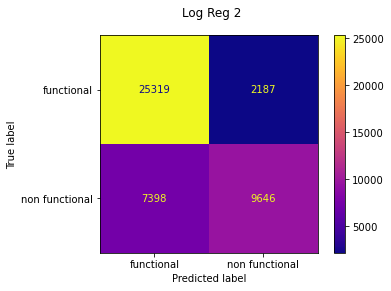

In [234]:
fig, ax = plt.subplots()

fig.suptitle("Log Reg 2")

plot_confusion_matrix(logreg_model_pipe_2, X_train, y_train, ax=ax, cmap="plasma");

In [237]:
y_pred = logreg_model_pipe_2.predict(X_train)

In [241]:
print(classification_report(y_train, y_pred))

                precision    recall  f1-score   support

    functional       0.77      0.92      0.84     27506
non functional       0.82      0.57      0.67     17044

      accuracy                           0.78     44550
     macro avg       0.79      0.74      0.75     44550
  weighted avg       0.79      0.78      0.77     44550



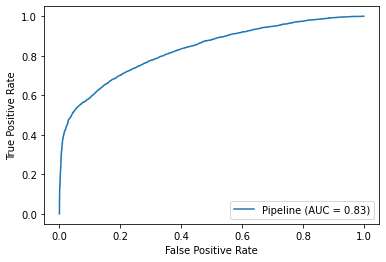

In [236]:
plot_roc_curve(logreg_model_pipe_2, X_train, y_train);

In [ ]:
# could keep refining, use SelectFromModel?  But not going to

## My take on a kNN

In [248]:
knn_pipe = Pipeline(steps=[('ct', CT),
                            ('knn', KNeighborsClassifier())])

In [249]:
knn_pipe.fit(X_train, y_train)

C:\Users\JonMc\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['gps_height', 'longitude',
                                                   'latitude', 'region_code',
                                                   'district_code', 'age']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                     

In [250]:
knn_pipe.score(X_train, y_train)

0.8805387205387205

In [269]:
y_pred_knn = knn_pipe.predict(X_train)

In [270]:
print(classification_report(y_train, y_pred_knn))

                precision    recall  f1-score   support

    functional       0.88      0.93      0.91     27506
non functional       0.88      0.80      0.84     17044

      accuracy                           0.88     44550
     macro avg       0.88      0.86      0.87     44550
  weighted avg       0.88      0.88      0.88     44550



## Second knn
### n_neighbors = 3

In [263]:
knn_pipe_2 = Pipeline(steps=[('ct', CT),
                            ('knn', KNeighborsClassifier(n_neighbors=3))])

In [264]:
knn_pipe_2.fit(X_train, y_train)

C:\Users\JonMc\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['gps_height', 'longitude',
                                                   'latitude', 'region_code',
                                                   'district_code', 'age']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                     

In [ ]:
knn_pipe.score(X_train, y_train)

In [267]:
y_pred_knn_2 = knn_pipe_2.predict(X_train)

In [271]:
print(classification_report(y_train, y_pred_knn))

                precision    recall  f1-score   support

    functional       0.88      0.93      0.91     27506
non functional       0.88      0.80      0.84     17044

      accuracy                           0.88     44550
     macro avg       0.88      0.86      0.87     44550
  weighted avg       0.88      0.88      0.88     44550



In [268]:
print(classification_report(y_train, y_pred_knn_2))

                precision    recall  f1-score   support

    functional       0.91      0.94      0.92     27506
non functional       0.90      0.85      0.87     17044

      accuracy                           0.90     44550
     macro avg       0.90      0.89      0.90     44550
  weighted avg       0.90      0.90      0.90     44550



## My take on a Decision Tree

In [254]:
dt_pipe = Pipeline(steps=[('ct', CT),
                            ('dt', DecisionTreeClassifier())])

In [255]:
dt_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['gps_height', 'longitude',
                                                   'latitude', 'region_code',
                                                   'district_code', 'age']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                     

In [256]:
dt_pipe.score(X_train, y_train)

0.9984736251402918

In [261]:
y_pred_dt = dt_pipe.predict(X_train)

In [262]:
print(classification_report(y_train, y_pred_dt))

                precision    recall  f1-score   support

    functional       1.00      1.00      1.00     27506
non functional       1.00      1.00      1.00     17044

      accuracy                           1.00     44550
     macro avg       1.00      1.00      1.00     44550
  weighted avg       1.00      1.00      1.00     44550



# More complex model (e.g. Random Forest)

In [ ]:
# Stefano working on Random Forest
# Terry doing kNN and basic decision tree

# Tune hyperparameters (either for simple or for more complex)

other Daniel tips:
- topic 25 classification workflow / expanded in topic 30
- randomized grid search over GridSearchCV